#### Imports

In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import os

from autoreject import AutoReject
from mne.preprocessing import ICA
from mne_icalabel import label_components
from pyprep.prep_pipeline import PrepPipeline
from scipy.io import loadmat, savemat

In [2]:
VISUALIZE = True
DEBUG = False

# Quiet down MNE and set default matplotlib figure size
mne.set_log_level("WARNING")
plt.rcParams["figure.figsize"] = (6, 4)

healthy_sample = ["509", "517", "519", "523", "533"]
depressed_sample = ["559", "561", "567", "587", "624"]
sample = healthy_sample + depressed_sample

#### Practice

In [414]:
if (False):

    data = loadmat("509_Depression_REST.mat")["EEG"][0][0]
    signal = data[15]
    channels = data[21][0]
    
    channel_names = [channel[0][0] for channel in channels if channel[0][0] not in ["CB1", "CB2"]]
    channel_locs = [[channel[j][0][0] for j in range(4,7)] for channel in channels if channel[0][0] not in ["CB1", "CB2"]]
    events = np.array([[data[25][0][i][j][0][0] for j in range(2)] for i in range(len(data[25][0]))])

    print(channels.shape)
    print()
    for a, b in zip(channel_names, channel_locs):
        print(f"{a} > {b}")

#### def load_data(file_name)

In [3]:
def load_data(file_name):
    data = loadmat(file_name)["EEG"][0][0]
    signals = data[15]/1e6
    channels = data[21][0]
    
    # Extract channel information
    channel_names = np.array([channel[0][0] for channel in channels])
    channels_to_keep = [i for i, name in enumerate(channel_names) if name not in {"CB1","CB2","EKG"}]
    channel_names = channel_names[channels_to_keep]
    channel_types = ["eeg" if name not in {"VEOG","HEOG"} else "eog" for name in channel_names]
    channel_locs = [[channel[j][0][0] for j in range(4,7)] for channel in channels if channel[0][0] not in {"CB1", "CB2", "EKG"}]

    # Scale coordinates cm->m and rotate them
    channel_locs = np.array(channel_locs) / 1000
    channel_locs = np.stack([
        channel_locs[:, 1],
        channel_locs[:, 0],
        channel_locs[:, 2]
    ], axis=1)

    # Process events information
    def extract_event_value(event): # string and integer events are stored differently
        return event[0] if isinstance(event[0], np.str_) else event[0][0]

    events = np.array([[extract_event_value(event[j]) for j in range(2)] for event in data[25][0]])
    events = [[int(event[0]), int(event[1])] for event in events if str(event[0]).isdigit()] # drop string events
    events = events[1:len(events)-1] # remove first and last event 17    
    
    # Parse events into key timestamps
    event_labels = [event[0] % 2 for event in events] # open or closed eyes
    switching_indeces = [i+1 for i in range(len(event_labels)-1) if event_labels[i] != event_labels[i+1]]
    switching_tstamps = [events[0][1]] + [events[i][1] for i in switching_indeces] + [events[-1][1]]

    # Slice epochs based on initial labels
    signals = signals[channels_to_keep]
    epochs = [signals[:, switching_tstamps[i]:switching_tstamps[i+1]] for i in range(len(switching_tstamps) - 1)]

    if event_labels[0] == 0:
        epochs_open = epochs[::2]
        epochs_closed = epochs[1::2]
    else:
        epochs_closed = epochs[::2]
        epochs_open = epochs[1::2]

    return (epochs_open, epochs_closed, channel_names, channel_locs, channel_types)


for idx, unit in enumerate(sample):
    file_name = unit + "_Depression_REST.mat"
    # load_data(os.path.join("data", file_name));
    load_data(os.path.join("depression_data", "matlab_files", file_name));

#### EEG - data loading, montage creation, info setting

64 (64, 42169)


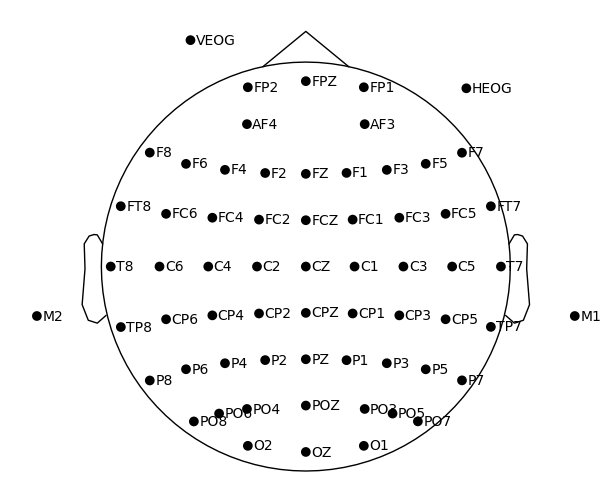

<Info | 8 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 62 EEG, 2 EOG
 custom_ref_applied: False
 dig: 65 items (3 Cardinal, 62 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
>


In [7]:
%matplotlib inline

# Load data
file_name = "543_Depression_REST"
file_path = os.path.join("depression_data", "matlab_files", f"{file_name}.mat")
epochs_open, epochs_closed, channel_names, channel_locs, channel_types = load_data(file_path)
print(len(channel_names), epochs_open[0].shape)

# print(channel_locs)

# Create and plot topographic map of montage
montage = mne.channels.make_dig_montage(
    ch_pos = dict(zip(channel_names, channel_locs)),
    coord_frame = 'head')
montage.plot(kind = 'topomap', show_names = True)

# Create MNE Info object
info = mne.create_info(ch_names = channel_names.tolist(),
                       sfreq    = 500,
                       ch_types = channel_types)
info.set_montage(montage, match_alias={'VEOG':'eog','HEOG':'eog'})
print(info)

#### EEG - scaling > high-pass filter > PREP

PREP includes: **1)** temporary filtering, **2)** line noise removal, **3)** robust CAR, **4)** bad channel interpolation & detection

In [8]:
def initial_processing(epoch, info):

    if len(epoch[0]) <= 303:
        print("Cannot process epoch because epoch electrode data shorter than 304")
        return

    # Apply high-pass filtering
    raw_eeg = mne.io.RawArray(epoch, info)
    hp_eeg = raw_eeg.copy().filter(l_freq=1, h_freq=100)

    # Apply PREP pipeline
    prep_params = {
        "ref_chs": "eeg",
        "reref_chs": "eeg",
        "line_freqs": []
    }

    print("Starting PREP...\n")

    prep = PrepPipeline(hp_eeg, prep_params, info.get_montage(), random_state=0)
    prep.fit()
    hp_prep_eeg = prep.raw

    print("\nInitial processing complete")
    print(f" > channels fixed after interpolation: {prep.interpolated_channels}")
    print(f" > channels still noisy after interpolation: {prep.still_noisy_channels}")

    return hp_prep_eeg

hp_prep_eeg = initial_processing(epochs_open[0], info)

Starting PREP...



2025-05-04 01:42:08,609 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['FC1', 'M2'], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['FC1'], 'bad_all': ['FC1', 'M2']}
2025-05-04 01:42:12,051 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['FC1', 'M2', 'TP8'], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['FC1', 'M2'], 'bad_all': ['FC1', 'M2', 'TP8']}
2025-05-04 01:42:12,129 - pyprep.reference - INFO - Iterations: 1
2025-05-04 01:42:15,278 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['FC1', 'M2', 'TP8'], 'bad_by_correlation': ['T8'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['FC1', 'M2'], 'bad_all': ['FC1', 'T8', 'M2', 'TP8']}
2025-05-04 01:42:15,367 - pyprep.reference -


Initial processing complete
 > channels fixed after interpolation: ['FC1', 'T8', 'M2']
 > channels still noisy after interpolation: []


*bad_by_deviation*
- channels with **excessive noise or abnormal amplitudes**
- their amplitude statistics deviate strongly from the rest (e.g., very high variance)

*bad_by_correlation*
- channels that are **poorly correlated with the rest of the EEG** (i.e., not capturing the same brain signals)
- based on pairwise correlation with surrounding channels — low correlation suggests disconnection or noise

*bad_by_ransac*
- channels detected as bad by a RANSAC-based approach (Random Sample Consensus)
- robustly finds channels whose signals **cannot be reconstructed well from subsets of other channels**

In [432]:
%matplotlib qt

if (VISUALIZE or False):
    
    # hp_eeg.plot(duration = 10, scalings=dict(eeg=50e-6), clipping = None, title="hp_eeg")
    # hp_eeg.compute_psd(n_fft=2048).plot()

    # hp_prep_eeg.plot(duration = 10, scalings=dict(eeg=50e-6), clipping = None, title="hp_prep_eeg")
    # hp_prep_eeg.compute_psd(n_fft=2048).plot(exclude='bads')

    hp_prep_eeg.plot(picks=["HEOG","VEOG"], duration = 10, scalings=dict(eeg=50e-6), clipping = None, title="hp_prep_eeg")

#### Epochs - generation, rejection, interpolation

In [9]:
def epochize_and_filter(eeg):

    epochs = mne.make_fixed_length_epochs(eeg, duration=4.0, preload=True, reject_by_annotation=False, proj=False)
    ar = AutoReject(n_interpolate=[1,2,4,8], random_state=0) # up to 15% (high fidelity) of 64 channels
    ar_epochs, reject_log = ar.fit_transform(epochs, return_log=True)

    # ar_epochs contains all the epochs, with bad ones marked
    # reject_log contains all the bad epochs

    return (epochs, ar_epochs, reject_log)

(epochs, ar_epochs, reject_log) = epochize_and_filter(hp_prep_eeg)

Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=8


In [434]:
%matplotlib qt

if (VISUALIZE or False):

    # Visualize EEG epochs

    # epochs.plot_image(combine='mean')
    # epochs.plot(scalings=dict(eeg=50e-6), show_scrollbars=True, n_epochs=5, title='EEG Epochs')
    # ar_epochs.plot(scalings=dict(eeg=50e-6), show_scrollbars=True, n_epochs=5, title='EEG Valid Epochs')

    # if reject_log.bad_epochs.any():
    #     epochs[reject_log.bad_epochs].plot(scalings=dict(eeg=100e-6), title='Rejected EEG Epochs (across all channels)')
    
    # reject_log.plot_epochs(epochs, scalings=dict(eeg=100e-6), title='Marked Epochs');
    # reject_log.plot('horizontal'); # Good, bad and inerpolated channels/epochs
    pass


print(len(epochs.drop_log))
print(len(ar_epochs.drop_log))
print()
print(epochs.drop_log)
print(ar_epochs.drop_log)
print()
print(epochs.selection)
print(ar_epochs.selection)

38
38

((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ())
(('AUTOREJECT',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('AUTOREJECT',), (), ('AUTOREJECT',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('AUTOREJECT',), ())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 37]


#### Independent Component Analysis (ICA)

In [10]:
def perform_ica(epochs, ica_method='fastica'):
    
    ica = ICA(n_components=0.9999999, random_state=0, method=ica_method, max_iter='auto', 
              fit_params=None if ica_method == 'fastica' else dict(extended=True))
    ica.fit(epochs, reject_by_annotation=True)
    
    print()
    print(ica)

    # TEST EOG
    eog_indices, eog_scores = ica.find_bads_eog(epochs, measure='correlation', threshold=0.6)
    print(f"\nExcluded EOG components: {eog_indices}")
    print(f"EOG scores: {eog_scores}\n")

    # # TEST ECG
    # ecg_indices, ecg_scores = ica.find_bads_ecg(epochs)
    # print(f"\nExcluded ECG components: {ecg_indices}")
    # print(f"ECG scores: {ecg_scores}\n")

    # TEST MUSCLE
    muscle_indices, muscle_scores = ica.find_bads_muscle(epochs)
    print(f"\nExcluded muscle components: {muscle_indices}")
    print(f"Muscle scores: {muscle_scores}\n")

    # if eog_indices:
    #     plot_ICA_components(ica, epochs, eog_scores, eog_indices, log_scale=False)

    # Label ICA components
    icalab = label_components(epochs, ica, method='iclabel')

    # “Other” is a catch-all that for non-classifiable components. 
    # We will stay on the side of caution and assume we cannot blindly remove these.
    for idx, label in enumerate(icalab['labels']):
        if label not in {'brain', 'other'}:
            print(idx, icalab['y_pred_proba'][idx], "\t", label)
            ica.exclude.append(idx)

    total_count = len(icalab['labels'])
    brain_other_count = total_count - len(ica.exclude)
    print(f"\nBrain & other components ratio: {brain_other_count}/{total_count}")
    print(f"ICALabel exclusions: {ica.exclude}\n")

    # Remove ICA component labeled as non-brain
    ica_epochs = epochs.copy()
    ica.apply(ica_epochs) # modifies in-place

    # # Interpolate bad channels (previously marked) using spline interpolation and reset their status
    # ica_epochs.interpolate_bads(reset_bads=True, method=dict(eeg="spline")); # potentially redundant line in automation

    return (ica, ica_epochs)

(ica, ica_epochs) = perform_ica(ar_epochs)


<ICA | epochs decomposition, method: fastica (fit in 138 iterations on 36000 samples), 62 ICA components (62 PCA components available), channel types: eeg, no sources marked for exclusion>

Excluded EOG components: []
EOG scores: [array([-0.28775408, -0.06109726,  0.01372025,  0.09464065,  0.01295778,
       -0.0709855 , -0.00460966, -0.01880722,  0.00299678, -0.00587076,
        0.0236339 , -0.03852537, -0.03046   , -0.04954033, -0.00583753,
        0.03195004, -0.00572685, -0.02764824, -0.02103051, -0.05746893,
       -0.01406899,  0.00264068,  0.01161161, -0.02022721, -0.00571702,
       -0.02272043, -0.03603515, -0.02259463, -0.05155659, -0.07763946,
       -0.07593903, -0.08349281, -0.03367363,  0.03635822,  0.0276555 ,
       -0.03638225, -0.01667899,  0.01122114, -0.00631023, -0.04838643,
       -0.00939975, -0.04107681,  0.01187076, -0.00537674, -0.04115451,
       -0.04372908,  0.07117922,  0.18647692, -0.04490259,  0.10456825,
       -0.04226555, -0.01777927, -0.10863431, -0

C:\Users\lukad\AppData\Local\Temp\ipykernel_11348\2107235232.py:29: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  icalab = label_components(epochs, ica, method='iclabel')
C:\Users\lukad\AppData\Local\Temp\ipykernel_11348\2107235232.py:29: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  icalab = label_components(epochs, ica, method='iclabel')


0 0.65780896 	 eye blink
1 0.3754204 	 muscle artifact
5 0.96849275 	 eye blink
10 0.92000014 	 eye blink
33 0.9536663 	 eye blink
34 0.8081302 	 eye blink
39 0.7980198 	 muscle artifact
47 0.5476604 	 eye blink
48 0.38794777 	 muscle artifact
52 0.58065134 	 muscle artifact
54 0.30019543 	 channel noise
60 0.76743364 	 muscle artifact

Brain & other components ratio: 50/62
ICALabel exclusions: [0, 1, 5, 10, 33, 34, 39, 47, 48, 52, 54, 60]



In [454]:
%matplotlib qt

if (VISUALIZE or False):

    # Plot ICA
    # ica.plot_sources(epochs, show_scrollbars=True, theme='dark', title="ICA (from filtered and CAR applied EEG)");

    # Plot the cleaned EEG data
    ar_epochs.plot(scalings=dict(eeg=50e-6), show_scrollbars=True, title="epochs")
    ica_epochs.plot(scalings=dict(eeg=50e-6), show_scrollbars=True, title="ica_epochs");

    # EOGs
    # ica_epochs.filter(l_freq=1, h_freq=100, picks=["VEOG", "HEOG"])
    # ica_epochs.info["bads"] = []
    # ica_epochs.plot(picks=["FP1", "FP2", "FPZ", "VEOG", "HEOG"], scalings=dict(eeg=50e-6), show_scrollbars=True, title="ica_epochs");

    print(len(ar_epochs.drop_log))
    print(len(ica_epochs.drop_log))
    print()
    print(ar_epochs.drop_log)
    print(ica_epochs.drop_log)
    print()
    print(ar_epochs.selection)
    print(ica_epochs.selection)

38
38

(('AUTOREJECT',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('AUTOREJECT',), (), ('AUTOREJECT',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('AUTOREJECT',), ())
(('AUTOREJECT',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('AUTOREJECT',), (), ('AUTOREJECT',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('AUTOREJECT',), ())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 37]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 37]


c:\Users\lukad\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


#### SAVING FILES (FIF & MAT)

In [11]:
### SAVE DATA AS FIF

def save_fif(file_name, epochs_open, epochs_closed):

    # Create the directory if it doesn't exist
    save_dir = "export_test_fif"
    os.makedirs(save_dir, exist_ok=True)

    if epochs_open:
        epochs_open_concat = mne.concatenate_epochs(epochs_open)
        file_path = os.path.join(save_dir, f"{file_name}_open_concat.fif")
        epochs_open_concat.save(file_path, overwrite=True)

    if epochs_closed:
        epochs_closed_concat = mne.concatenate_epochs(epochs_closed)
        file_path = os.path.join(save_dir, f"{file_name}_closed_concat.fif")
        epochs_closed_concat.save(file_path, overwrite=True)

save_fif(file_name, [ica_epochs], [])

C:\Users\lukad\AppData\Local\Temp\ipykernel_11348\2238539478.py:12: RuntimeWarning: This filename (export_test_fif\543_Depression_REST_open_concat.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_open_concat.save(file_path, overwrite=True)


In [12]:
### SAVE DATA AS MAT

def save_mat(file_name, info, epochs_open, epochs_closed):

    # Create the directory if it doesn't exist
    save_dir = "export_test_mat"
    os.makedirs(save_dir, exist_ok=True)

    epochs_open_data = mne.concatenate_epochs(epochs_open).get_data() if epochs_open else []
    epochs_closed_data = mne.concatenate_epochs(epochs_closed).get_data() if epochs_closed else []
    channel_names_data = np.array(info["ch_names"], dtype=object).reshape(-1, 1)

    print(epochs_open_data.shape)

    data = {
        'epochs_open': epochs_open_data,
        'epochs_closed': epochs_closed_data,
        'channel_names': channel_names_data
    }

    file_path = os.path.join(save_dir, f"{file_name}_processed.mat")
    # savemat(file_path, {'data': data})
    savemat(file_path, data)
    
save_mat(file_name, info, [ica_epochs], [])

(18, 64, 2000)


In [ ]:
### SAVE DATA AS MAT

def save_mat(file_name, info, epochs_open, epochs_closed, channel_locs):

    # Create the directory if it doesn't exist
    save_dir = "export_test_mat"
    os.makedirs(save_dir, exist_ok=True)

    epochs_open_data = mne.concatenate_epochs(epochs_open).get_data() if epochs_open else []
    epochs_closed_data = mne.concatenate_epochs(epochs_closed).get_data() if epochs_closed else []
    channel_names_data = np.array(info["ch_names"], dtype=object).reshape(-1, 1)

    print(epochs_open_data.shape)

    data = {
        'epochs_open': epochs_open_data,
        'epochs_closed': epochs_closed_data,
        'channel_names': channel_names_data
    }

    file_path = os.path.join(save_dir, f"{file_name}_processed.mat")
    savemat(file_path, data)
    
save_mat(file_name, info, [ica_epochs], [])

#### TOOLS

In [439]:
def compare_raws(raw1, raw2):
    
    # Compute the difference
    diff_data = raw1._data - raw2._data
    # Create a new Raw object with the difference
    diff_raw = mne.io.RawArray(diff_data, raw1.info)
    # Plot the difference
    diff_raw.plot(duration = 10, scalings=dict(eeg=50e-6), clipping = None, title="Raw Comparison")

# compare_raws(hp_prep_eeg, ica_epochs)

In [440]:
def plot_ICA_components(ica, raw, scores, indices, log_scale=False):
    # Plot ICA EOG
    ica.plot_scores(scores)
    ica.plot_properties(raw, picks=indices, log_scale=log_scale)
    # ica.plot_sources(raw, show_scrollbars=False)

c:\Users\lukad\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


#### TO BE INTEGRATED / CONSIDERED